<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предпросмотр" data-toc-modified-id="Предпросмотр-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предпросмотр</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Проверка-на-тестовой" data-toc-modified-id="Проверка-на-тестовой-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка на тестовой</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Предпросмотр

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import re
from sklearn.pipeline import make_pipeline

import nltk
import spacy
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import  plot_confusion_matrix

# настройки
warnings.filterwarnings("ignore")
pd.set_option('display.max_column', None)

# константы заглавными буквами
RANDOM_STATE = 42

In [2]:
# Откроем и прочитаем файл
pth1 = 'datasets/toxic_comments.csv'


if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    print('wrong somethings')

In [3]:
#Посмотрим данные 
display(data)
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
# Удалим ненужный столбец
data = data.drop('Unnamed: 0', axis=1)

0    143106
1     16186
Name: toxic, dtype: int64
8.841344371679229


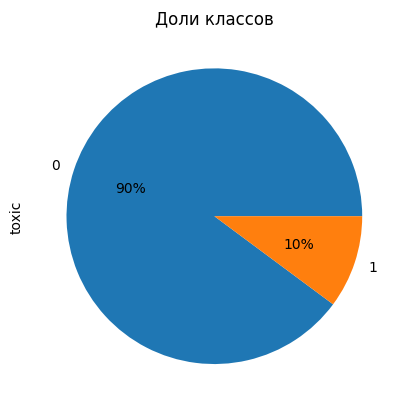

In [5]:
#Посмотрим на распределение классов
print(data['toxic'].value_counts())
print(data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1])
data['toxic'].value_counts().plot(kind='pie', title='Доли классов', autopct='%1.0f%%');

**Вывод:** Данные нуждаются в предварительной обработке. Также наблюдается дисбаланс классов в целевом признаке.

## Подготовка

In [6]:
#Создадим лемматизатор и очистим данные от лишних символов
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(text): 
    text = re.sub(r"[^a-zA-Z']", ' ', text).lower()
    ' '.join(text.split())
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc]) 
    

In [7]:
data['lemm_text'] = data['text'].apply(lemmatize)

In [8]:
# df = pd.read_csv('datasets/lemm_toxic_comments.csv')

In [9]:
df = data.copy()
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour I be s...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can not make any real suggestion on ...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you rememb...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when y...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there s no actual article for...
159290,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [10]:
#Разобьем данные на выборки
features = df['lemm_text']
target = df['toxic']

train_features, test_features, train_target, test_target = train_test_split(
    features, target, random_state=RANDOM_STATE, test_size=0.2)

In [11]:
train_features

45155        you claim to have    scavenge the un and ng...
60904          please do not vandalize page   as you do ...
92242            large moon      should not it say large...
74757          be not bake cook     accord to the articl...
7198      I be sure the judge smile too    when you cons...
                                ...                        
119879        first of all   editor theredpenofdoom be n...
103694                             and decide to become gay
131932    john bull vs   adolf hitler      look at the p...
146867    october         you have a lot to learn about ...
121958       I be sorry   tip   the deduction be obvious...
Name: lemm_text, Length: 127433, dtype: object

In [12]:
# Загрузим стоп-слова для исключения из данных
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nossp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Векторизуем признаки 
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [14]:
# Создадим метрику качества
f1 = make_scorer(f1_score)

**Вывод:** Данные подготовлены для обучения модели.

## Обучение

**Для обучения возьмем модель логистической регрессии и  градиентного бустинга. Лучшую модель проверим на тестовой выборке.**

### LogisticRegression

In [15]:
# Перебираемые гиперпараметры
grid_space_lr = {
    'logisticregression__max_iter': [100, 200, 500, 1000],                      
    'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],                                   
}

In [16]:
# обучающая модель
lr = LogisticRegression()

pipline_lr = make_pipeline(count_tf_idf, lr)

# обучим модель
grid_lr= RandomizedSearchCV(pipline_lr, grid_space_lr,  verbose=1, cv=3, n_jobs=-1, scoring=f1)
grid_lr.fit(train_features, train_target) 

print('Best hyperparameters are: '+str(grid_lr.best_params_))
print('Best score is: '+str(grid_lr.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters are: {'logisticregression__solver': 'lbfgs', 'logisticregression__max_iter': 200}
Best score is: 0.7243846444757756


- Fitting 3 folds for each of 10 candidates, totalling 30 fits
    - Best hyperparameters are: {'logisticregression__solver': 'lbfgs', 'logisticregression__max_iter': 1000
    - Best score is:  0.7243846444757756

### LightGBM

In [17]:
param_dist = {"lgbmclassifier__max_depth": [5, 10, 15, 20],
              "lgbmclassifier__learning_rate" : [0.05, 0.1, 0.15, 0.3],
              "lgbmclassifier__num_leaves": [32, 150, 200],
              "lgbmclassifier__n_estimators": [200, 300, 400, 500],
}

In [18]:
model_lgb = LGBMClassifier(random_state=RANDOM_STATE)
pipline_lgb = make_pipeline(count_tf_idf, model_lgb)

grid_search = RandomizedSearchCV(pipline_lgb, param_dist, cv = 3, 
                                      verbose=10, n_jobs=-1, scoring=f1)
grid_search.fit(train_features, train_target) 

print('Best hyperparameters are: '+str(grid_search.best_params_))
print('Best score is: '+str(grid_search.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters are: {'lgbmclassifier__num_leaves': 32, 'lgbmclassifier__n_estimators': 300, 'lgbmclassifier__max_depth': 20, 'lgbmclassifier__learning_rate': 0.3}
Best score is: 0.7748685322742012


- Fitting 3 folds for each of 10 candidates, totalling 30 fits
    - Best hyperparameters are: {'num_leaves': 32, 'n_estimators': 200, 'max_depth': 20 , 'learning_rate': 0.3}
    - Best score is: 0.7759699880151837

**Вывод:** Градиентный бустинг показал лучшие результаты, ее и возьмем.

## Проверка на тестовой

In [19]:
# Узнаем распределение классов в тестовой выборке
test_target.value_counts()

0    28658
1     3201
Name: toxic, dtype: int64

In [20]:
tf_idf = count_tf_idf.fit_transform(train_features)
print(tf_idf.shape)

tf_idf_test = count_tf_idf.transform(test_features)
tf_idf_test.shape

(127433, 131630)


(31859, 131630)

In [ ]:
lgbm = LGBMClassifier(num_leaves=32, n_estimators=200, 
                      max_depth=20, learning_rate=0.3,random_state=RANDOM_STATE)
lgbm.fit(tf_idf, train_target)
predictions = lgbm.predict(tf_idf_test)

print(f'f1=',f1_score(test_target, predictions))

f1= 0.7802063297779331

In [ ]:
#Выведем матрицу путаницы
plot_confusion_matrix(lgbm, tf_idf_test, test_target, normalize='true'); 
plot_confusion_matrix(lgbm, tf_idf_test, test_target); 

**Выводы:** Модель соответствует требованиям заказчика. Метрика f1=0.78. Модель определяет позитивные комменты с вероятностью 99% и негативные с вероятностью 70%.

## Выводы

**В ходе выполнения задачи мы создали алгоритм подготовки данных для обучения моделей. Определили лучшую модель обучения, и получили на модели метрику f1=0.78. Модель определяет позитивные комменты с вероятностью 99% и негативные с вероятностью 70%.
Условия заказчика выполнены.**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны